# Create ratemaps 
Jump to the bottom of the notebook for the generation of rate maps

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatialspikefields.fields as tr
import re
import pnnmec
import multiprocessing
import shutil

par = {'speed_filter': 5, # m/s
    'pos_fs': 100 ,
    'f_cut': 6 ,
    'spat_binsize': 0.02 ,
    'spat_smoothing': 0.025,
    'grid_stepsize': 0.1 ,
    'box_xlen': 1 ,
    'box_ylen': 1 ,
    'spike_size': 10,
    'field_max_wall_extent':0.1,
    'field_min_bins':12
}

# Load project in python using expipe

In [3]:
project_path = "testing/"

project = expipe.get_project(project_path)
actions = project.actions

In [4]:
tr.

# Create, plot and save the rate map
Set parameters below. Make `rate_map` is the relevant function. The folder specified by `save_folder` must exist.

In [5]:
binsize = 0.02
smoothing = 0.025
save_folder = 'figures/' # must exist!
figsize = [5, 5]

import exdir
import exdir.plugins.quantities
import exdir.plugins.git_lfs
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import spatialspikefields.fields as tr
import gc

def make_rate_map(x,y,t,sptr, action_id, binsize, smoothing, basename, figsize = [5,5]):
    fig = plt.figure(figsize=figsize)
    rate_map = tr.spatial_rate_map(x,y,t,sptr, binsize = binsize, 
                                   box_xlen = 1, box_ylen = 1, smoothing = smoothing)
    
    ax = plt.imshow(rate_map, origin="lower")
    plt.xticks([])
    plt.yticks([])
    
    fig = plt.figure(figsize=figsize)
    plt.plot(x, y, 'k', alpha = 0.3)
    
    x_spike = interp1d(t,x)(sptr)
    y_spike = interp1d(t,y)(sptr)
    # plt.xticks([])
    # plt.yticks([])
    #plt.axis('equal')
    #plt.axis([0,1,0,1])
    
    ax = plt.scatter(x_spike, y_spike, s = 30, c = [[0.7, 0.2, 0.2]])
    plt.xticks([])
    plt.yticks([])
    plt.close(fig)
    
    fig = plt.figure(figsize=figsize)
    np.nan_to_num(rate_map, copy = False) # inplace
    autocorr = pnnmec.fftcorrelate2d(rate_map, rate_map, mode = 'full', normalize = True)
    ax = plt.imshow(autocorr, origin="lower")
    plt.xticks([])
    plt.yticks([])
    plt.close(fig)

# Create rate maps for all experiments and store in action

In [7]:
all_units = []
action_list = []

for action_id in project.actions:
    action  = actions[action_id]                                                                                                                                                        

    if action.type != 'Recording':
        continue # go to next action if not recording

    data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"
    root_group = exdir.File(data_path, plugins=[exdir.plugins.quantities,
                                                exdir.plugins.git_lfs])
    
    if not "processing" in root_group:
        continue
    
    electrophysiology_group = root_group["/processing/electrophysiology/"]
    
    for channel_name in electrophysiology_group:
        channel = electrophysiology_group[channel_name]
        print(channel_name)
        
        # assume channel name is channel_group_X and find X:
        channel_name_pattern = r"channel_group_(\d+)"
        channel_id = re.match(channel_name_pattern, channel_name)[1]
        
        if not "UnitTimes" in channel:
            continue
        
        channel_units = channel["UnitTimes"]
        
        for unit_id in channel_units:
            unit = channel_units[unit_id]
            unit_path = unit.name
            basename = "figures/{}_{}_{}".format(action_id, channel_id, unit_id)
            
            if action_id == "1751-200317-02" and channel_id == "2" and unit_id == "0":
                print("Skipping", basename)
                continue
            all_units.append((action, action_id, channel_id, unit_id, basename))

channel_group_0
channel_group_1
channel_group_2
channel_group_3
channel_group_4
channel_group_5
channel_group_6
channel_group_7


In [8]:
def process(args):
    action, action_id, channel_id, unit_id, basename = args
    if os.path.exists(basename + "_ratemap.npy"):
        print("Skipping existing", basename)
        return

    print("Creating", basename)

    data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"
    unit_path = pnnmec.unit_path(channel_id, unit_id)
    
    x, y, t, speed, sptr = pnnmec.load_data(data_path, unit_path, par)
    make_rate_map(x,y,t,sptr,action_id, basename=basename, binsize = binsize, 
                  smoothing = smoothing, figsize = figsize)

Creating figures/1806-031218-2_1_3
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511


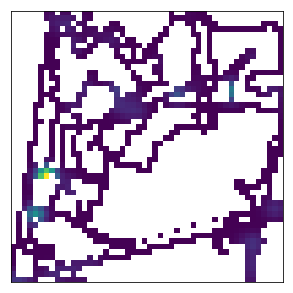

In [13]:
process(all_units[3])

Creating figures/1806-031218-2_0_0
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511


/home/alessiob/anaconda3/envs/expipe/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Creating figures/1806-031218-2_0_1
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511


/home/alessiob/anaconda3/envs/expipe/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Creating figures/1806-031218-2_0_2
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511
Creating figures/1806-031218-2_1_3
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511
Creating figures/1806-031218-2_1_4
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511
Creating figures/1806-031218-2_1_5
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511
Creating figures/1806-031218-2_2_6
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511
Creating figures/1806-031218-2_2_7
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511
Creating figures/1806-031218-2_2_8
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511
Creating figures/1806-031218-2_4_10
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511
Creating figures/1806-031218-2_4_11
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511

/home/alessiob/anaconda3/envs/expipe/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Creating figures/1806-031218-2_6_20
Removed 13.68 % invalid measurements in path
Maximum speed 8.57495271620511


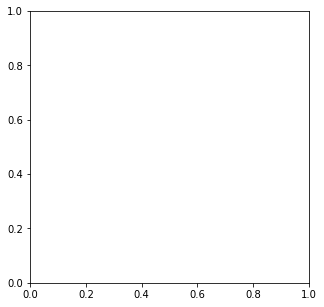

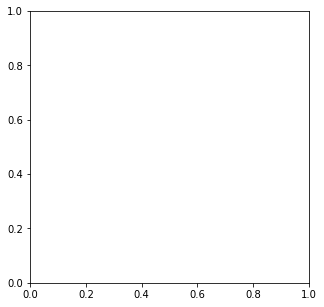

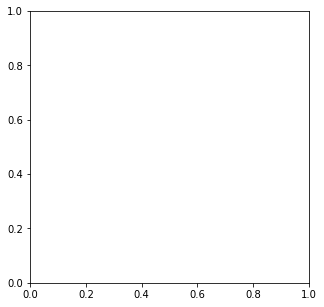

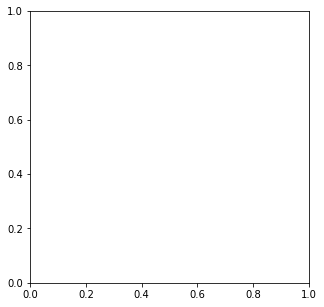

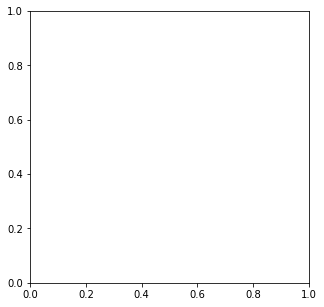

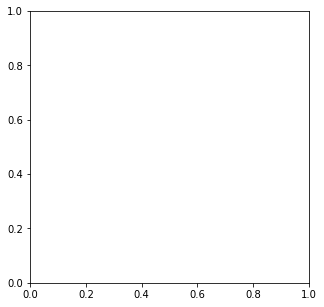

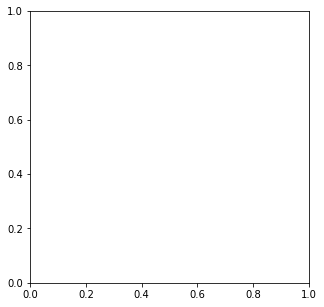

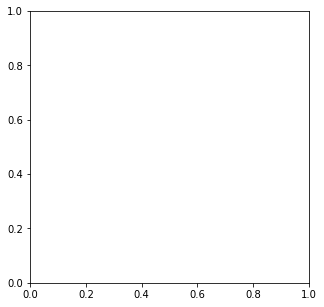

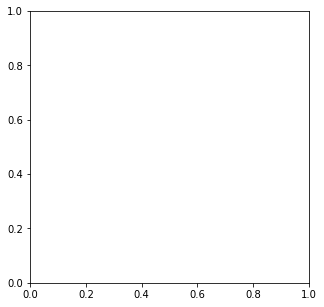

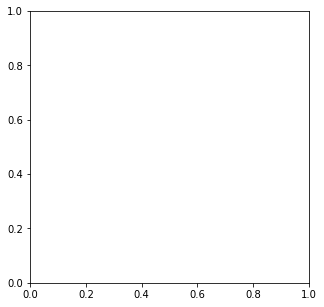

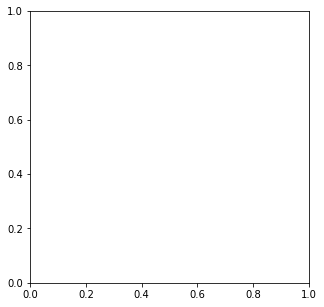

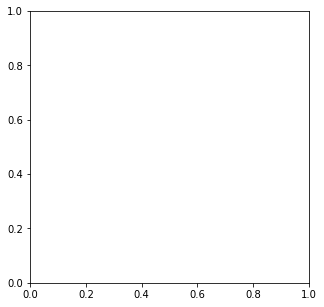

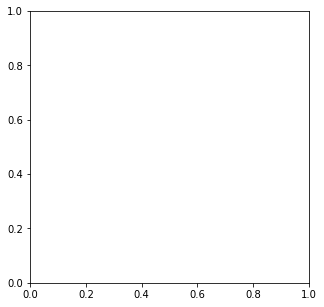

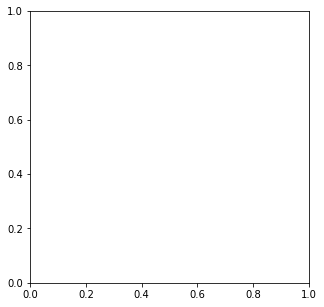

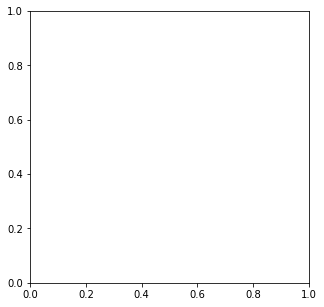

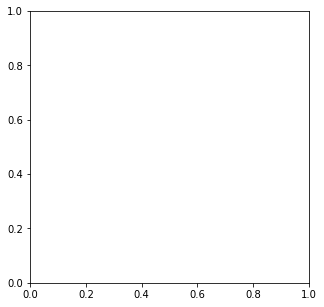

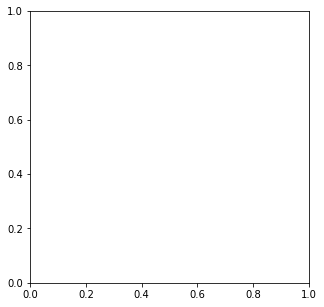

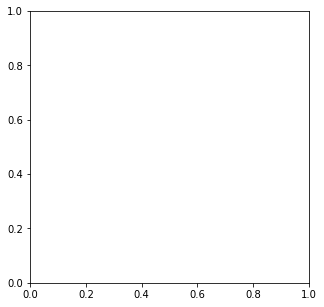

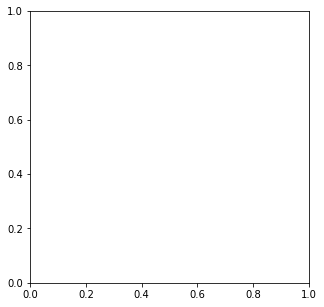

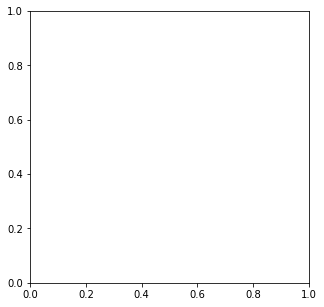

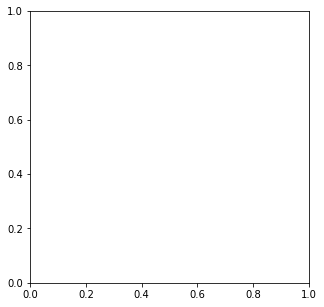

In [9]:

for args in all_units[0]:
    process(args)
    
    # Make sure to clean up memory
    gc.collect()

In [ ]:
crm_action = project.require_action("create_rate_maps")
crm_action.data["figures"] = "figures"
output_path = pathlib.Path(project_path) / "actions" / "create_rate_maps" / "data"
output_path.mkdir(exist_ok=True, parents=True)
shutil.copytree("figures", output_path / "figures")